<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Blockchain Data Science</h1>
        <h2>Block Statistics</h2>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import gzip
import numpy as np
import pandas as pd
import sys
import igraph
from tqdm import tqdm 
import pickle
import os
import numpy as np
from pprint import pprint

import watermark

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext watermark

In [2]:
%watermark -i -n -v -m -g -iv

igraph     0.7.1
numpy      1.16.2
pandas     0.24.2
watermark  1.8.1
matplotlib 3.1.0
Wed Sep 25 2019 2019-09-25T13:30:17-04:00

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : ba5aa1bd09e23ac188b12f070ea55cd8dcac1182


# Graph Analysis

In principle, the blockchain is just that, a chain. However, since there is no central authority coordinating the efforts of the miners we sometimes end up with two blocks competing for validation at the same time. This results in a temporary fork in the chain. After one of the two competing blocks gets a successor, the losing candidate block is automatically invalidated and its transactions get returned to the mempool.

In [3]:
G = igraph.Graph()
blocks = {}

line_count = 0
block_count = 0

if os.path.exists("data/undirected.pickle"):
    G = igraph.read("data/undirected.pickle")
    blocks = pickle.load(open("data/blocks.pickle", "rb"))
else:
    for line in tqdm(gzip.open('data/blocks.dat.gz', 'rt'), total=566015):
        fields = line.strip().split()

        line_count += 1

        if line_count == 1:
            continue

        # block_count timestamp hash previous_block_hash n_transactions txid reward difficulty bits nonce size
        timestamp = fields[1]
        node_i = fields[2]
        node_j = fields[3]
        ntranx = int(fields[4])
        size = int(fields[-1])

        if node_j not in blocks:
            blocks[node_j] = block_count
            block_count += 1
            node_j = blocks[node_j]
            G.add_vertex(node_j)
        else:
            node_j = blocks[node_j]

        if node_i not in blocks:
            blocks[node_i] = block_count
            block_count += 1
            node_i = blocks[node_i]
            G.add_vertex(node_i)
        else:
            node_i = blocks[node_i]

        G.vs[node_i]["prev"] = node_j,
        G.vs[node_i]["timestamp"] = timestamp,
        G.vs[node_i]["ntrax"] = ntranx,
        G.vs[node_i]["size"] = size

        G.add_edge(node_i, node_j)
    
    G.save('data/undirected.pickle', 'pickle')
    pickle.dump(blocks, open("data/blocks.pickle", "wb"))

In [4]:
G.summary()

'IGRAPH UN-- 566015 566014 -- \n+ attr: name (v), ntrax (v), prev (v), size (v), timestamp (v)'

Here we generated a graph containing all the blocks in order to identify which ones need to be removed. Blocks at the end of a chain have degree 1 (only connecting to the previous block and without any blocks connected to them).

In [5]:
degrees = np.array(G.degree()) # The degree of each block
ids = np.array(G.vs["name"]) # Unique id

dangling = ids[degrees<2] # leaves have degree 1.
dangling = dangling[1:-1] # Remove root and most recent leaf

Starting from these leaf blocks we traverse the graph back until we reach a block with degree higher than two. This is the branch block (one connection to a parent block and at least two child blocks).

In [6]:
remove = []
branches = []

for count, source in enumerate(dangling):
    current = source
    branches.append([])

    while degrees[current] <=2:
        branches[-1].append(current)
        remove.append(current)
        current = G.vs[current]["prev"][0] 

Turns out that all we have are single blocks. There are no parallel chains of greater length.

In [7]:
len(remove) == len(branches)

True

In [8]:
G.delete_vertices(remove)

After we remove the extraneous blocks, we find that we have $N$ nodes connected by $N-1$ edges. A perfect chain.

In [9]:
G.summary()

'IGRAPH UN-- 565964 565963 -- \n+ attr: name (v), ntrax (v), prev (v), size (v), timestamp (v)'

In [10]:
block_ids = [item[0] for item in blocks.items() if item[1] not in remove]

In [11]:
len(block_ids)

565964

Now we have a list with all the valid block_ids

In [12]:
pprint(block_ids[:10])

['000000000378457ab84153a2425351a5f4388096d0dffeba3c98b35edffa0003',
 '0000000000000218aaaf48f61598693408303d8d8fc0740ff1085d3461c301d1',
 '000000000000000020b9312b04143e00d1d6db7a985bcd35cdac365708652dbf',
 '000000000000054a5801dee3870560494d949540ba505b9f060aafed23b88d06',
 '0000000000344ce7b827a5da8502e3dd4cff0b77681aaaeff82a82dd15fb14fa',
 '0000000000000000001841a837e050917241e090047cdbbff807d5434dd8d383',
 '000000000000000001079c558e0ba9df21baa817989631afeafe914bb877868a',
 '00000000000007afcc908c1ee71ef1e470df10a4f920746c2794956d674df1dc',
 '000000000000059dfd4d67a031a184e904c40d845b451ce744d77c1c64448ca1',
 '000000000000000006355c07b36bac6990cce128610d674851096b8c9745a3ee']


however, this list still contains the Coinbase block, so we must remove it:

In [13]:
'0000000000000000000000000000000000000000000000000000000000000000' in block_ids

True

In [14]:
block_ids.remove('0000000000000000000000000000000000000000000000000000000000000000')

# Clean dataset

With the list of valid blocks in hand, we can now filter out all the relevant data. Let's start by rereading the original file

In [15]:
data = pd.read_csv('data/blocks.dat.gz', sep=' ', index_col=0)

Let's take a look to make sure everything is ok

In [16]:
data.head()

,timestamp,hash,previous_block_hash,n_transactions,txid,reward,difficulty,bits,nonce,size
block_count,,,,,,,,,,
0,1231006505,000000000019d6689c085ae165831e934ff763ae46a2a6...,0000000000000000000000000000000000000000000000...,1,4a5e1e4baab89f3a32518a88c31bc87f618f76673e2cc7...,5000000000,1.0,486604799,2083236893,285
1,1231469665,00000000839a8e6886ab5951d76f411475428afc90947e...,000000000019d6689c085ae165831e934ff763ae46a2a6...,1,0e3e2357e806b6cdb1f70b54c3a3a17b6714ee1f0e68be...,5000000000,1.0,486604799,2573394689,215
2,1231469744,000000006a625f06636b8bb6ac7b960a8d03705d1ace08...,00000000839a8e6886ab5951d76f411475428afc90947e...,1,9b0fc92260312ce44e74ef369f5c66bbb85848f2eddd5a...,5000000000,1.0,486604799,1639830024,215
3,1231470173,0000000082b5015589a3fdf2d4baff403e6f0be035a5d9...,000000006a625f06636b8bb6ac7b960a8d03705d1ace08...,1,999e1c837c76a1b7fbb7e57baf87b309960f5ffefbf2a9...,5000000000,1.0,486604799,1844305925,215
4,1231470988,000000004ebadb55ee9096c9a2f8880e09da59c0d68b1c...,0000000082b5015589a3fdf2d4baff403e6f0be035a5d9...,1,df2b060fa2e5e9c8ed5eaf6a45c13753ec8c63282b2688...,5000000000,1.0,486604799,2850094635,215


In [17]:
data.dtypes

timestamp                int64
hash                    object
previous_block_hash     object
n_transactions           int64
txid                    object
reward                   int64
difficulty             float64
bits                     int64
nonce                    int64
size                     int64
dtype: object

In [18]:
data.shape

(566014, 10)

## Remove dangling blocks

Now we keep only the good block_ids

In [19]:
data = data.set_index('hash').reindex(block_ids).reset_index().dropna()

In [20]:
data.head()

,hash,timestamp,previous_block_hash,n_transactions,txid,reward,difficulty,bits,nonce,size
0,000000000378457ab84153a2425351a5f4388096d0dffe...,1278237139,00000000070f1a5834e86a8306716f8996752a9bc27ca2...,1,d0d33d13aafba2ddeba00172e5bebb9f2b05c4c0c307c2...,5000000000,1.940480e+01,470626626,241519822,216
1,0000000000000218aaaf48f61598693408303d8d8fc074...,1335831604,0000000000000a57f17bbe39279fdb4996757c25fc19f2...,10,910eb03b277057d80d262fffba76dd1e7660ef65f1e97b...,5000200000,1.508590e+06,436936439,3345554202,3017
2,000000000000000020b9312b04143e00d1d6db7a985bcd...,1411123732,00000000000000001a61ee54acdbbd001875da79872eca...,497,e82054dd2086ce2e6c613da438791c5901f5a5be0fe74a...,2507539665,2.982973e+10,405068777,2775086569,261617
3,000000000000054a5801dee3870560494d949540ba505b...,1314417553,000000000000016621de182bbed7f40415fe98f9dc6111...,63,e1c0902512cb02113b73c8b8a856139fea2b7407e8db07...,5019366401,1.805701e+06,436816518,4241934319,63239
4,0000000000344ce7b827a5da8502e3dd4cff0b77681aaa...,1284000941,00000000002a7559b84f901cfcd8edc99f7700b2e9c495...,3,b5de90257c4b9bba48a1af12c74e0a763f7133450a7f84...,5001000000,7.128849e+02,459009510,2729335466,2293


In [21]:
data.shape

(565963, 10)

Now we make sure that the blocks are sorted by timestamp and assign to each a sequential block-height

In [22]:
data = data.sort_values("timestamp", ascending=True)
data["height"] = np.arange(data.shape[0])

And we check that the corresponding height is correctly assigned. From [bitcoin.com](https://www.blockchain.com/btc/block-height/150000) we know that the hash of block at height 556875 is *[0000000000000000002f64b2e9d0883eae4abf36cbd4cf536d90ed2102b07e40](https://www.blockchain.com/btc/block-height/556875)*. 

In [23]:
data.loc[data["height"] == 556875, "hash"] == "0000000000000000002f64b2e9d0883eae4abf36cbd4cf536d90ed2102b07e40"

59300    True
Name: hash, dtype: bool

Now we turn the data frame into a timeseries by converting the timestamp to a datetime object and assigning it to the index

In [24]:
data.index = pd.to_datetime(data['timestamp'].astype('int'), unit='s')

In [25]:
data.head()

,hash,timestamp,previous_block_hash,n_transactions,txid,reward,difficulty,bits,nonce,size,height
timestamp,,,,,,,,,,,
2009-01-03 18:15:05,000000000019d6689c085ae165831e934ff763ae46a2a6...,1231006505,0000000000000000000000000000000000000000000000...,1,4a5e1e4baab89f3a32518a88c31bc87f618f76673e2cc7...,5000000000,1.0,486604799,2083236893,285,0
2009-01-09 02:54:25,00000000839a8e6886ab5951d76f411475428afc90947e...,1231469665,000000000019d6689c085ae165831e934ff763ae46a2a6...,1,0e3e2357e806b6cdb1f70b54c3a3a17b6714ee1f0e68be...,5000000000,1.0,486604799,2573394689,215,1
2009-01-09 02:55:44,000000006a625f06636b8bb6ac7b960a8d03705d1ace08...,1231469744,00000000839a8e6886ab5951d76f411475428afc90947e...,1,9b0fc92260312ce44e74ef369f5c66bbb85848f2eddd5a...,5000000000,1.0,486604799,1639830024,215,2
2009-01-09 03:02:53,0000000082b5015589a3fdf2d4baff403e6f0be035a5d9...,1231470173,000000006a625f06636b8bb6ac7b960a8d03705d1ace08...,1,999e1c837c76a1b7fbb7e57baf87b309960f5ffefbf2a9...,5000000000,1.0,486604799,1844305925,215,3
2009-01-09 03:16:28,000000004ebadb55ee9096c9a2f8880e09da59c0d68b1c...,1231470988,0000000082b5015589a3fdf2d4baff403e6f0be035a5d9...,1,df2b060fa2e5e9c8ed5eaf6a45c13753ec8c63282b2688...,5000000000,1.0,486604799,2850094635,215,4


Now we can easily see that block 556875 is the 10 year anniversary block. It was mined almost exactly 10 years after the Genesis block

In [26]:
print(data.loc[data["height"] == 0].index)
print(data.loc[data["height"] == 556875].index)

DatetimeIndex(['2009-01-03 18:15:05'], dtype='datetime64[ns]', name='timestamp', freq=None)
DatetimeIndex(['2019-01-03 18:19:56'], dtype='datetime64[ns]', name='timestamp', freq=None)


# Timeseries

With the block data formulated as a timeseries, we can do some pretty interesting stuff already. For example, plot the total number of transactions per month alongside the average block size (x10 for plotting convenience):

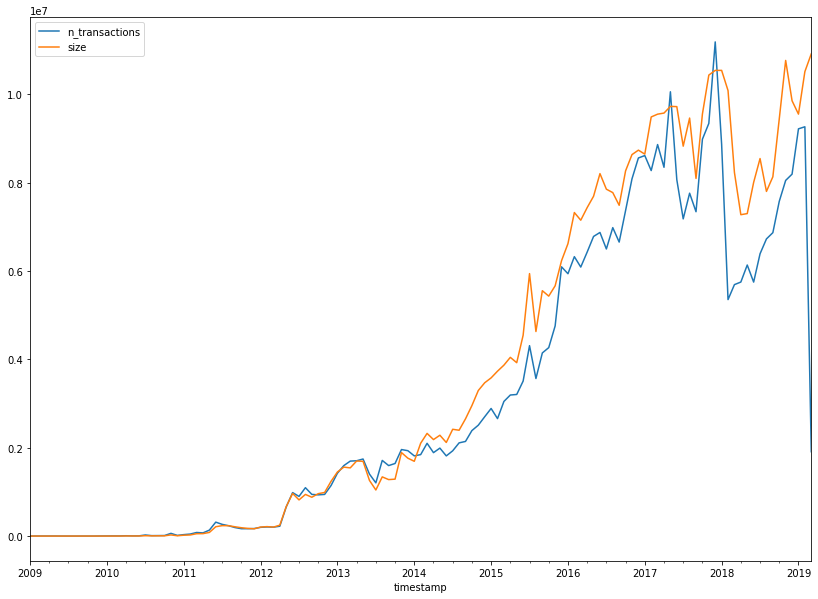

In [27]:
data[['n_transactions']].resample('M').sum().plot()
(data[['size']].resample('M').mean()*10).plot(ax=plt.gca())
plt.gcf().set_size_inches(14,10)

From this plot it's already clear that the block size is impacting the maximum number of transactions that can be handled by Bitcoin. The peak at the end of 2017 was do to the last Bitcoin bubble where it hit $20,000

Now we load the bitcoin prices obtained from [coinmarketcap](https://coinmarketcap.com/currencies/bitcoin/)

In [28]:
bitcoin = pd.read_csv('data/bitcoin.csv', parse_dates=['Date'], index_col=0)

In [29]:
bitcoin.head()

,Open*,High,Low,Close**,Volume,Market Cap
Date,,,,,,
2019-03-20,4070.79,4089.46,4031.11,4087.48,10175916388,71942444088
2019-03-19,4032.69,4082.22,4023.81,4071.19,9344919956,71647703828
2019-03-18,4029.97,4071.56,4009.12,4032.51,9646954186,70958165407
2019-03-17,4047.72,4054.12,4006.41,4025.23,8221625400,70821939585
2019-03-16,3963.90,4077.04,3961.66,4048.73,9856166973,71227967573


Unfortunately, this data is only reported at the day level and doesn't cover the entire span we are interested in:

In [30]:
bitcoin.index.min()

Timestamp('2013-04-28 00:00:00')

On the bright side, we can easily map our block information to this level of resolution to make the comparison easier

In [31]:
bitcoin = bitcoin.join(data['size'].resample('D').mean())
bitcoin = bitcoin.join(data['n_transactions'].resample('D').sum())
bitcoin = bitcoin.join(data['reward'].resample('D').mean())
bitcoin = bitcoin.join(data['difficulty'].resample('D').mean())
bitcoin = bitcoin.dropna() #NaNs are introduced since the price data include more recent days than the block data

In [32]:
bitcoin.head()

,Open*,High,Low,Close**,Volume,Market Cap,size,n_transactions,reward,difficulty
Date,,,,,,,,,,
2019-03-06,3897.08,3919.51,3871.46,3903.94,9175291529,68609885776,1.235649e+06,277863.0,1.279759e+09,6.071846e+12
2019-03-05,3759.83,3903.92,3745.18,3896.38,10174126415,68470655400,1.029825e+06,285716.0,1.269403e+09,6.071846e+12
2019-03-04,3845.09,3867.38,3733.75,3761.56,9029175788,66094551587,1.104754e+06,304188.0,1.261377e+09,6.071846e+12
2019-03-03,3862.27,3875.48,3836.91,3847.18,7253558152,67592376373,1.003580e+06,353683.0,1.264413e+09,6.071846e+12
2019-03-02,3855.32,3874.61,3832.13,3864.42,7578786076,67888255371,1.155579e+06,335864.0,1.269010e+09,6.071846e+12


Let's take a look at the average block reward

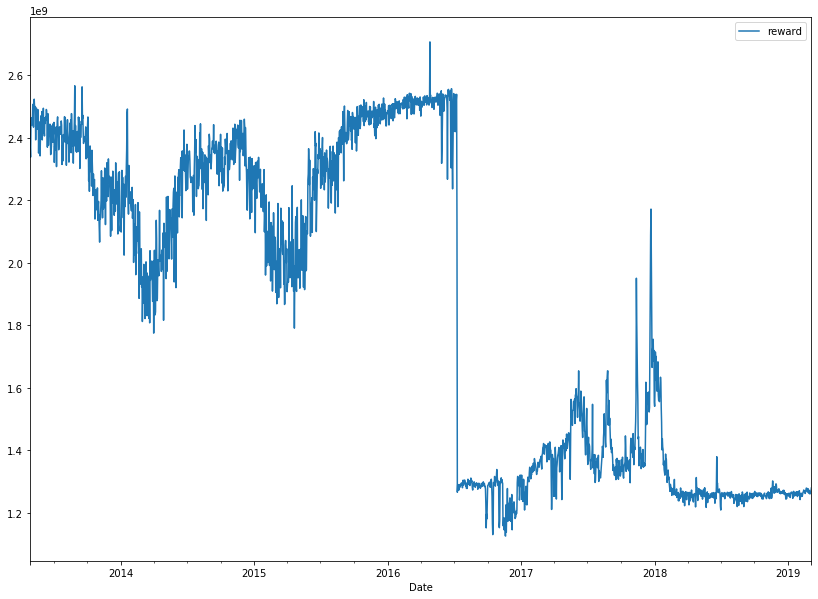

In [33]:
bitcoin[['reward']].plot()
plt.gcf().set_size_inches(14,10)

Where we can clearly see a halving happening around 2016 when the block reward passed from 25BTC to 12.5BTC. The  previous halving can be found in the full dataset

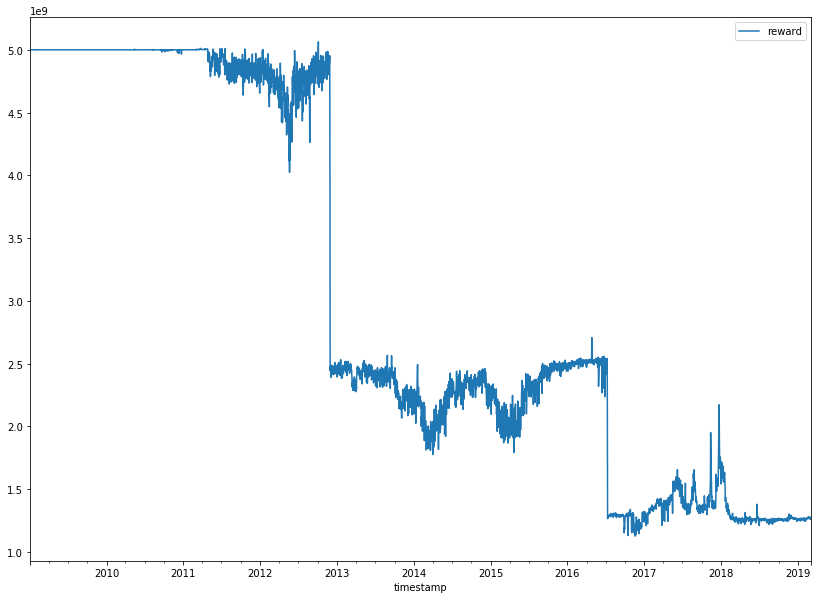

In [34]:
data[['reward']].resample('D').mean().plot()
plt.gcf().set_size_inches(14,10)

The spikes you see in 2017 are again due to the bitcoin bubble and the resulting increase in fees paid by users of the system. Dips are an artifact of the way the data was collected and highlight something very interesting.

When preparing the block dataset, I extracted only the value of the first output of the coinbase transaction in each block. When the coinbase transaction has more than one output, this will result in an apparently smaller reward. Multiple outputs indicate that the block was mined through a mining collaboration where several miners work together to try to beat the remaining miners in being the first to find the solution. When a solution is found, the reward is shared.

The large dips in some periods indicate that mining collaborations were very prevalent in those periods. For example, for block 95420 the reward is apparently just 44 satoshi, but this is due to the fact that this coinbase transaction has [two dozen outputs](https://www.blockchain.com/btc/tx/80853f00959702a11c2be709c6f4f3ffeec4e0bab3a2050a2eb9593e253cd3b6) 

In [35]:
data.loc[data['height']==95420, "reward"]

timestamp
2010-12-04 05:04:30    44
Name: reward, dtype: int64

Surprisingly, while the total number of transactions did prove senstive to the bubble price hike, it has been recovering much more rapidly than the price itself.

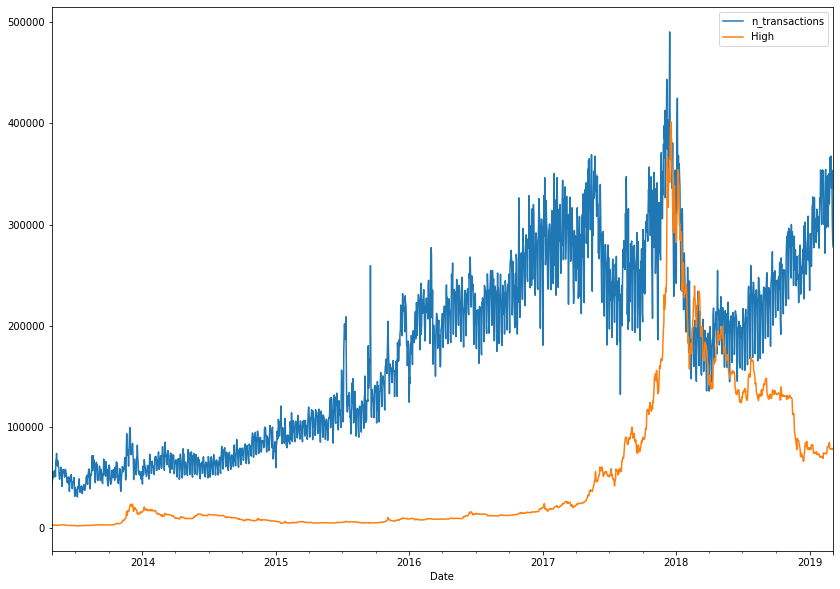

In [36]:
bitcoin[['n_transactions']].plot()
(bitcoin[['High']]*20).plot(ax=plt.gca()) #x20 for ease of comparison on the same scale
plt.gcf().set_size_inches(14,10)

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>